## Computation of IV of an european call option using ANN in a BS setting

### Project overview:

<ol>
<li>Creation of the dataset of option prices</li>
<li>Model creation & fitting</li>
<li>Prediction errors visualization</li>
</ol>

In [1]:
import keras
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2024-02-27 16:55:43.000782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#The function to replicate (compute the price/k of the option), we do that to have a model the most general possible
def black_scholes_call(SoverK, T, r, sigma):
    d1 = (np.log(SoverK) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = SoverK * norm.cdf(d1) - 1 * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [3]:
#Creating the dataset
size = 10000
SoverKs = np.random.uniform(0.5, 1.4, size=size) #random prices
maturities = np.random.uniform(0.2, 1.0, size=size)
sigmas = np.random.uniform(0.01, 1.0, size=size)
rates = np.random.uniform(0.02, 0.1, size=size)
calls = np.array([black_scholes_call(SoverK, T, r, sigma) for (SoverK, T, r, sigma) in zip(SoverKs, maturities, rates, sigmas)])

In [4]:
data = pd.DataFrame()
data["SoverK"] = SoverKs
data["Call Price"] = calls
data["Maturity"] = maturities
data["RFR"] = rates
data["Volatility"] = sigmas
data

,SoverK,Call Price,Maturity,RFR,Volatility
0,1.165510,2.953089e-01,0.990778,0.064398,0.377170
1,0.888579,5.808843e-02,0.505389,0.078334,0.343212
2,0.758725,1.086932e-01,0.446989,0.073690,0.865936
3,1.079407,2.153529e-01,0.465418,0.041809,0.579302
4,1.394313,4.563135e-01,0.844964,0.075442,0.165053
...,...,...,...,...,...
9995,1.067163,1.666766e-01,0.383958,0.092737,0.431649
9996,0.647795,1.287333e-49,0.420789,0.055835,0.044210
9997,0.694884,8.212948e-02,0.384109,0.095401,0.930915
9998,1.385161,4.461017e-01,0.429581,0.052890,0.558697


### 2.Model Creation & fitting
|Model Input| Model Output|
|:-------:|:-----:|
|StockPrice/Strike|Implied Vol|
|Time to maturity|
|RFR|
|CallPrice/Strike|

In [5]:
train, test = train_test_split(data, test_size=0.25)
train_x = train[["SoverK", "Call Price", "Maturity", "RFR"]]
train_y = np.array(train["Volatility"]).reshape(len(train["Volatility"]),1)
test_x = test[["SoverK", "Call Price", "Maturity", "RFR"]]
test_y = np.array(test["Volatility"]).reshape(len(test["Volatility"]),1)

In [10]:
test

(7500, 4)

In [7]:
model = keras.Sequential(
    [
    keras.layers.Dense(400, activation='relu', input_dim=train_x.shape[1], kernel_initializer="glorot_uniform"),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(1)
    ]
)


2024-02-27 16:56:29.347415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.compile(loss='mse', optimizer='adam')

In [9]:
model.fit(train_x, train_y, epochs=500, batch_size=7500, validation_split=0.0, verbose=1)

Epoch 1/500
1/1 [==============================] - 0s 471ms/step - loss: 0.3044
Epoch 2/500
1/1 [==============================] - 0s 143ms/step - loss: 0.1286
Epoch 3/500
1/1 [==============================] - 0s 144ms/step - loss: 0.1041
Epoch 4/500
1/1 [==============================] - 0s 140ms/step - loss: 0.1252
Epoch 5/500
1/1 [==============================] - 0s 146ms/step - loss: 0.0977
Epoch 6/500
1/1 [==============================] - 0s 142ms/step - loss: 0.0914
Epoch 7/500
1/1 [==============================] - 0s 143ms/step - loss: 0.1000
Epoch 8/500
1/1 [==============================] - 0s 141ms/step - loss: 0.0999
Epoch 9/500
1/1 [==============================] - 0s 182ms/step - loss: 0.0927
Epoch 10/500
1/1 [==============================] - 0s 168ms/step - loss: 0.0883
Epoch 11/500
1/1 [==============================] - 0s 140ms/step - loss: 0.0913
Epoch 12/500
1/1 [==============================] - 0s 142ms/step - loss: 0.0940
Epoch 13/500
1/1 [===================

In [144]:
ypred = model.predict(test_x)

79/79 [==============================] - 0s 1ms/step


### 3.Visualization of prediction errors

In [145]:
diff2 = test_y - ypred 
rmse = 0
for x in diff2:
    rmse+= x**2
rmse = np.sqrt((1/len(diff2))*rmse)
rmse

array([0.06664301])

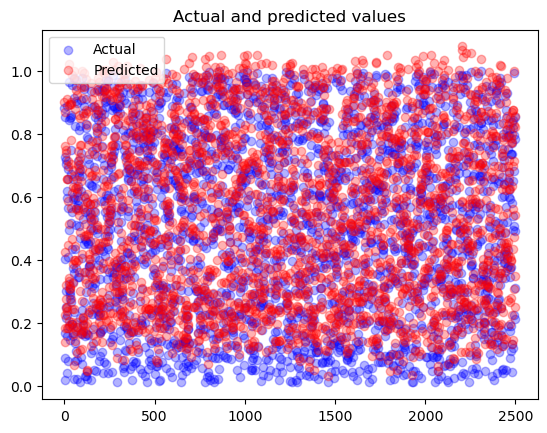

In [146]:
_, ax = plt.subplots()

ax.scatter(x = range(0, test_y.size), y=test_y, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, ypred.size), y=ypred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.legend()
plt.show()

Text(0.01, 0.5, 'RMSE:[0.06664301]')

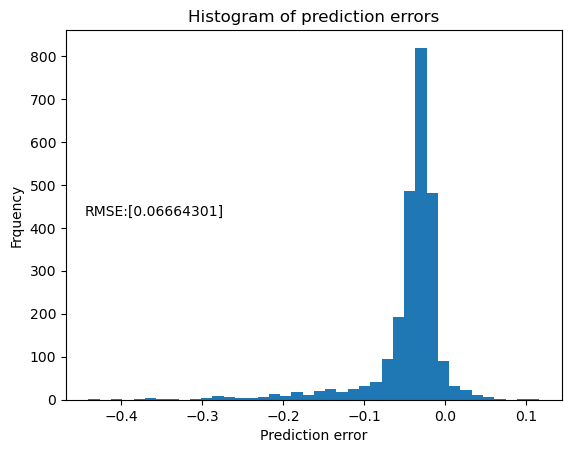

In [147]:
diff = test_y - ypred
plt.hist(diff, bins=40)
plt.title("Histogram of prediction errors")
plt.ylabel("Frquency")
plt.xlabel("Prediction error")
plt.text(0.01, 0.5, f"RMSE:{rmse}", transform=ax.transAxes)

In [148]:
from scipy.optimize import brentq
import time

In [167]:
def get_iv(SoverK, T, r, v_market):
    def objective_function(sigma):
        return black_scholes_call(SoverK, T, r, sigma) - v_market
    if abs(objective_function(0.01))<1e-10:
        return 0.01
    if abs(objective_function(1.0))<1e-10:
        return 1.0
    return brentq(objective_function, 0.01, 1.0)

SoverKbis = test_x["SoverK"].values.tolist()
maturitiesbis = test_x["Maturity"].values.tolist()
ratesbis = test_x["RFR"].values.tolist()
callsbis = test_x["Call Price"].values.tolist()
st = time.time()
ybrentq = []
for i in range(len(test_y)):
    print(i)
    ybrentq.append(get_iv(SoverKbis[i], maturitiesbis[i], ratesbis[i], callsbis[i]))
et = time.time()
print(f"Time elapsed:{et-st}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [177]:
diff3 = test_y - np.array(ybrentq).reshape(len(ybrentq), 1)
rmse2 = 0
for x in diff3:
    rmse2+= x**2
rmse2 = np.sqrt((1/len(diff3))*rmse2)
rmse2

array([0.01150135])

Text(0.01, 0.5, 'RMSE:[0.01150135]')

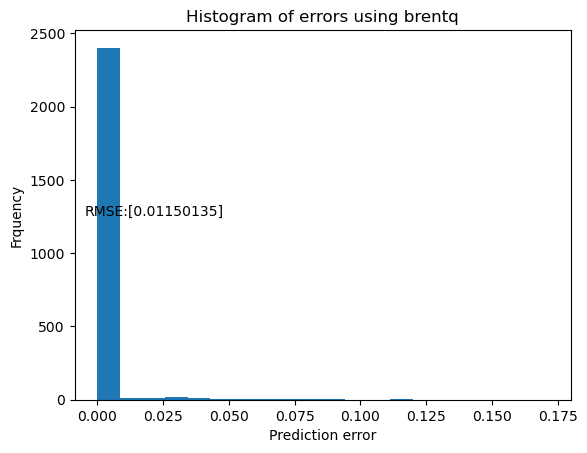

In [179]:
plt.hist(diff3, bins=20)
plt.title("Histogram of errors using brentq")
plt.ylabel("Frquency")
plt.xlabel("Prediction error")
plt.text(0.01, 0.5, f"RMSE:{rmse2}", transform=ax.transAxes)